In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [ ]:
!pip install langgraph langchain_community langchain_huggingface chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 3.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 3.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
os.environ["GOOGLE_API_KEY"] = "********************"
os.environ["TAVILY_API_KEY"] = "********************"
os.environ["GROQ_API_KEY"]= "********************"
os.environ["LANGCHAIN_API_KEY"] = "********************"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="llama-3.1-8b-instant")

In [ ]:
llm.invoke("Tell me about India")

AIMessage(content="India is a vast and diverse country located in South Asia. It is the seventh-largest country in the world by land area and the second-most populous country with over 1.38 billion people. Here are some key facts about India:\n\n**Geography and Climate**\n\nIndia is a vast country with a diverse geography, including:\n\n* Mountains: The Himalayas, the world's highest mountain range, stretch across the northern border of India.\n* Plains: The Indo-Gangetic Plain, one of the world's most fertile regions, covers much of northern India.\n* Coastlines: India has a long coastline along the Arabian Sea, the Bay of Bengal, and the Indian Ocean.\n* Climate: India's climate varies from tropical in the south to temperate in the north. The country experiences three main seasons: summer (April to June), monsoon (July to September), and winter (October to March).\n\n**Culture and History**\n\nIndia has a rich cultural heritage, with a history dating back over 5,000 years. The countr

In [ ]:
url= "https://lilianweng.github.io/posts/2023-06-23-agent/"

In [ ]:
WebBaseLoader(url).load()

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [ ]:
docs = [WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [ ]:
docs_list = [item for sublist in docs for item in sublist]

In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=80, chunk_overlap=20)

In [ ]:
doc_splitter = text_splitter.split_documents(docs_list)

In [ ]:
len(doc_splitter)

351

In [ ]:
doc_splitter

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [ ]:
vectorstore = Chroma.from_documents(
    documents=doc_splitter,
    collection_name='rag-chrome',
    embedding=embeddings
)

In [ ]:
retriever = vectorstore.as_retriever()

In [ ]:
retriever_tool=create_retriever_tool(
    retriever,
    "retriever_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
)

In [ ]:
tools = [retriever_tool]

In [ ]:
retriever = ToolNode([retriever_tool])

## Creating AI Agent using LangGraph

In [ ]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
def ai_assistant(state:AgentState):
    print("--- CALL AGENT ---")
    messages = state['messages']

    if len(messages)>1:
        last_message = messages[-1]
        question = last_message,content
        prompt = PromptTemplate(
            template="""You are a helpful assistant, ready to provide an answer to any question asked. Here is the question: {question}.""",
            input_variable=["question"]
        )
        chain = prompt | llm
        reponse = chain.invoke({"question": question})
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [ ]:
class grade(BaseModel):
    binary_score:str = Field(description="Relevance score 'yes' or 'no'")

In [ ]:
def grade_documents(state: AgentState):
    llm_with_structure = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""You are a grader tasked with determining whether a document is relevant to a user's question.
                Here is the document: {context}
                Here is the user’s question: {question}
                If the document contains information related to the user’s question, mark it as relevant.
                Respond with 'yes' or 'no' to indicate whether the document is relevant to the question.""",
                input_variable = ["context", "question"]
    )
    chain = prompt | llm_with_structure

    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context":docs})
    score = scored_result.binary_score

    if score == "yes":
        print("--- DOC IS RELEVANT ---")
        return "generator" #this should be a node name
    else:
        print("--- DOCS IS NOT RELEVANT ---")
        return "rewriter"

In [ ]:
hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [ ]:
def generate(state: AgentState):
    print("--- GENERATE ---")
    messages = state["messages"]

    question = messages[0].content
    last_message = messages[-1]
    doc = last_message.content

    prompt = hub.pull("rlm/rag-prompt")
    rag_chain = prompt | llm
    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"RESPONSE : {response}")

    return {"messages": [response]}

In [ ]:
from langchain_core.messages import HumanMessage
def rewrite(state: AgentState):
    print("--- TRANSFROM QUERY ---")
    messages = state["messages"]
    question = messages[0].content

    message = [HumanMessage(content=f"""Examine the input and try to understand the underlying meaning or intent.
                    Here is the original question: {question}
                    Please rephrase it into an improved version:""")]
    response = llm.invoke(message)
    return {"message": [response]}

In [ ]:
workflow = StateGraph(AgentState)
workflow.add_node("AI_ASSIATANT", ai_assistant)
workflow.add_node("VECTOR_RETRIEVER", retriever)
workflow.add_node("QUERY_GENERATOR", generate)
workflow.add_node("QUERY_REWRITER", rewrite)

In [ ]:
workflow.add_edge(START, "AI_ASSIATANT")
workflow.add_conditional_edges("AI_ASSIATANT",
                            tools_condition,
                            {"tools": "VECTOR_RETRIEVER",
                                END: END,})
workflow.add_conditional_edges("VECTOR_RETRIEVER",
                            grade_documents,
                            {"generator": "QUERY_GENERATOR",
                            "rewriter": "QUERY_REWRITER"})
workflow.add_edge("QUERY_GENERATOR", END)
workflow.add_edge("QUERY_REWRITER", "AI_ASSIATANT")

In [ ]:
app = workflow.compile()

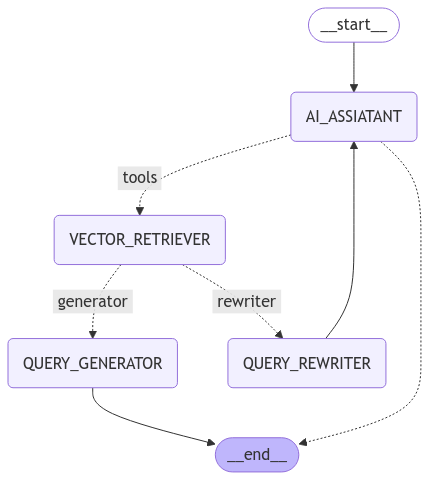

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [ ]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

--- CALL AGENT ---


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='d8bb5e9c-28de-4712-a849-9a04b2ad672e'),
  AIMessage(content="An autonomous agent is a system that operates independently and makes decisions without direct human intervention. It uses sensors, data, and algorithms to perceive its environment, reason about its actions, and adapt to new situations. Autonomous agents can be found in various fields, such as robotics, artificial intelligence, and cybersecurity.\n\nIn the context of artificial intelligence, autonomous agents are often used in applications like:\n\n1. Robotics: Autonomous robots can navigate and interact with their environment without human control.\n2. Autonomous vehicles: Self-driving cars, drones, and other vehicles use sensors and AI to navigate and make decisions.\n3. Cybersecurity: Autonomous systems can detect and respond to cyber threats in real-time.\n4. Customer service: Chatbots and virtual assistants c

In [ ]:
app.invoke({"messages":["what is a prompt engineering explain me in terms of agents and langchain?"]})

--- CALL AGENT ---
--- DOC IS RELEVANT ---
--- GENERATE ---
RESPONSE : content="Prompt engineering refers to the process of designing and optimizing prompts to elicit desired responses from large language models (LLMs). It involves selecting and ordering examples, providing clear instructions, and using techniques like chain-of-thought prompting to guide the model's reasoning process. \n\nIn the context of agents and LangChain, prompt engineering is crucial for building effective and efficient LLM-powered autonomous agents. By carefully crafting prompts, agents can communicate with LLMs to achieve desired outcomes, such as generating responses, completing tasks, or making decisions." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 18667, 'total_tokens': 18774, 'completion_time': 0.142666667, 'prompt_time': 1.227324262, 'queue_time': 0.164873123, 'total_time': 1.369990929}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp

{'messages': [HumanMessage(content='what is a prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='4f063c2a-5ada-41c6-bd00-855f3b8d2ae5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g47m', 'function': {'arguments': '{"query": "prompt engineering in langchain and LLM agents"}', 'name': 'retriever_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 405, 'total_tokens': 430, 'completion_time': 0.033333333, 'prompt_time': 0.026743442, 'queue_time': 0.052306435000000005, 'total_time': 0.060076775}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c5e685ab6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ba26b618-bf96-4389-9e7e-55073ea1d362-0', tool_calls=[{'name': 'retriever_blog_posts', 'args': {'query': 'prompt engineering in langchain and LLM agents'}, 'id': 'call_g47m', 'type': 'tool_call'}], usage_metadata={'i

In [ ]:
app.invoke({"messages":["what is capital of india?"]})

--- CALL AGENT ---


{'messages': [HumanMessage(content='what is capital of india?', additional_kwargs={}, response_metadata={}, id='188c105e-5b13-4e0f-a712-43c240c1c930'),
  AIMessage(content='New Delhi is the capital of India.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 396, 'total_tokens': 405, 'completion_time': 0.012, 'prompt_time': 0.025995461, 'queue_time': 0.020162148, 'total_time': 0.037995461}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'stop', 'logprobs': None}, id='run-8bdffcbb-f13d-4ef1-9d9d-9400eb652e5c-0', usage_metadata={'input_tokens': 396, 'output_tokens': 9, 'total_tokens': 405})]}